In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.hidden_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.learning_rate = learning_rate

    def forward(self, inputs):
        h_prev = np.zeros((self.hidden_size, 1))
        self.cache = {'h': [], 'inputs': inputs}
        
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
            self.cache['h'].append(h)
            h_prev = h
        
        self.cache['h'] = np.array(self.cache['h'])
        output = np.dot(self.Why, h) + self.by
        return output, h

    def backward(self, d_output, h_last):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros_like(h_last)

        for t in reversed(range(len(self.cache['inputs']))):
            dh = np.dot(self.Why.T, d_output) + dh_next
            dh_raw = (1 - self.cache['h'][t] ** 2) * dh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, self.cache['inputs'][t].reshape(1, -1))
            dWhh += np.dot(dh_raw, self.cache['h'][t - 1].T) if t > 0 else 0
            dh_next = np.dot(self.Whh.T, dh_raw)

        dWhy += np.dot(d_output, self.cache['h'][-1].T)
        dby += d_output

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -1, 1, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_weights(self, dWxh, dWhh, dWhy, dbh, dby):
        self.Wxh -= self.learning_rate * dWxh
        self.Whh -= self.learning_rate * dWhh
        self.Why -= self.learning_rate * dWhy
        self.bh -= self.learning_rate * dbh
        self.by -= self.learning_rate * dby

    def train(self, X_train, y_train, epochs=100, window_size=10):
        epoch_losses = []
        for epoch in range(epochs):
            loss = 0
            for X, y in zip(X_train, y_train):
                
                X_windows = [X[i:i+window_size] for i in range(len(X) - window_size + 1)]
                
                X_window = X_windows[-1]
                
                output, h_last = self.forward(X_window)
                
                loss += np.sum((output - y.reshape(-1, 1)) ** 2)
                
                d_output = 2 * (output - y.reshape(-1, 1))
                dWxh, dWhh, dWhy, dbh, dby = self.backward(d_output, h_last)
                
                self.update_weights(dWxh, dWhh, dWhy, dbh, dby)
            
            epoch_losses.append(loss / len(X_train))
            print(f"Epoch {epoch + 1}, Loss: {loss / len(X_train)}")
        
        plt.plot(range(epochs), epoch_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epochs vs Loss')
        plt.show()

    def predict(self, X):
        output, _ = self.forward(X)
        return output

In [8]:
def generate_synthetic_data_univariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data = np.sin(t) + noise_level * np.random.randn(seq_length)
    return data

def generate_synthetic_data_multivariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data1 = np.sin(t) + noise_level * np.random.randn(seq_length)
    data2 = np.cos(t) + noise_level * np.random.randn(seq_length)
    return np.column_stack([data1, data2])

Epoch 1, Loss: 0.45802965050804756
Epoch 2, Loss: 0.1355445869532957
Epoch 3, Loss: 0.060336058835197486
Epoch 4, Loss: 0.05702282491975667
Epoch 5, Loss: 0.055329454403865976
Epoch 6, Loss: 0.0542810041058968
Epoch 7, Loss: 0.0536704893624959
Epoch 8, Loss: 0.05345565777624106
Epoch 9, Loss: 0.05368641828492848
Epoch 10, Loss: 0.05437788294360027
Epoch 11, Loss: 0.0555424904196818
Epoch 12, Loss: 0.0571103681040006
Epoch 13, Loss: 0.059108898937517855
Epoch 14, Loss: 0.06157140029146863
Epoch 15, Loss: 0.0643919522685668
Epoch 16, Loss: 0.06749026642893748
Epoch 17, Loss: 0.07076245931629313
Epoch 18, Loss: 0.07408313295121374
Epoch 19, Loss: 0.0772046221545892
Epoch 20, Loss: 0.07987023833000909
Epoch 21, Loss: 0.08176470506361627
Epoch 22, Loss: 0.08264619149919392
Epoch 23, Loss: 0.08230849621829181
Epoch 24, Loss: 0.08065956544433356
Epoch 25, Loss: 0.07797107400106285
Epoch 26, Loss: 0.07471923685635122
Epoch 27, Loss: 0.07142150142446212
Epoch 28, Loss: 0.06843109347574697
Epoch

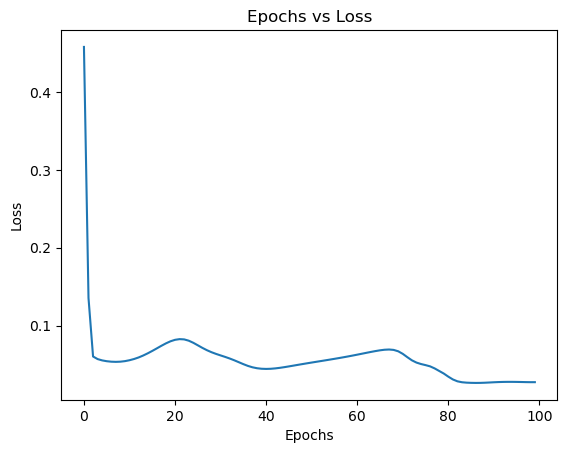

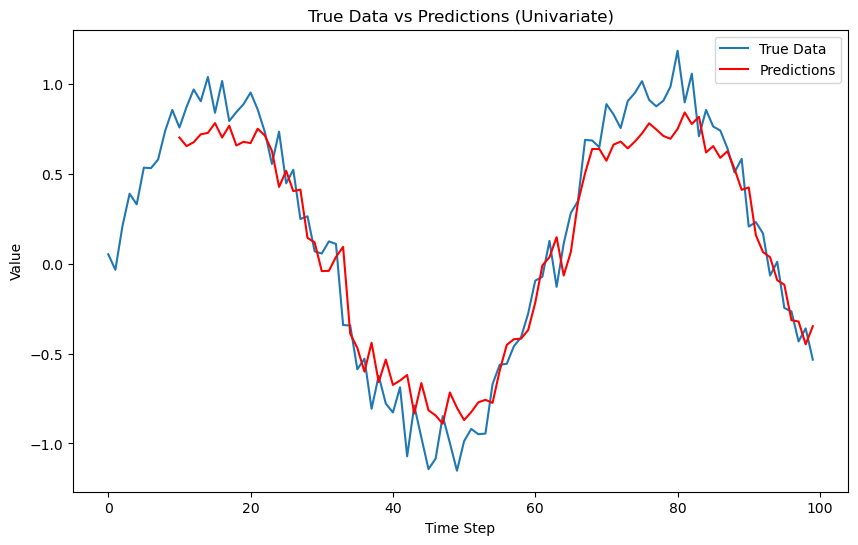

In [9]:
seq_length = 100
data_univariate = generate_synthetic_data_univariate(seq_length)

window_size = 10
X_train_univariate = [data_univariate[i:i+window_size] for i in range(len(data_univariate) - window_size)]
y_train_univariate = [data_univariate[i + window_size] for i in range(len(data_univariate) - window_size)]

rnn_univariate = SimpleRNN(input_size=1, hidden_size=20, output_size=1, learning_rate=0.01)
rnn_univariate.train(X_train_univariate, y_train_univariate, epochs=100, window_size=window_size)

predictions_univariate = [rnn_univariate.predict(X_window) for X_window in X_train_univariate]

predictions_univariate = np.array(predictions_univariate).reshape(-1)
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_univariate, label="True Data")
plt.plot(range(window_size, seq_length), predictions_univariate, label="Predictions", color='red')
plt.legend()
plt.title('True Data vs Predictions (Univariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

Epoch 1, Loss: 0.8693110122153093
Epoch 2, Loss: 0.24384662303927992
Epoch 3, Loss: 0.06448299296265717
Epoch 4, Loss: 0.04662875752203944
Epoch 5, Loss: 0.040194473525860835
Epoch 6, Loss: 0.03892801060961978
Epoch 7, Loss: 0.038482602639537004
Epoch 8, Loss: 0.037657657468382504
Epoch 9, Loss: 0.03651246721107786
Epoch 10, Loss: 0.03555531474608384
Epoch 11, Loss: 0.034957475516475274
Epoch 12, Loss: 0.03460998664944032
Epoch 13, Loss: 0.03447687315885359
Epoch 14, Loss: 0.03434539634856859
Epoch 15, Loss: 0.03414054005628124
Epoch 16, Loss: 0.03395424286502727
Epoch 17, Loss: 0.03379314483743817
Epoch 18, Loss: 0.03361025508412901
Epoch 19, Loss: 0.033401282852640476
Epoch 20, Loss: 0.033254824089936054
Epoch 21, Loss: 0.03330677225232857
Epoch 22, Loss: 0.03349381907759913
Epoch 23, Loss: 0.03369373842352463
Epoch 24, Loss: 0.0338805284904416
Epoch 25, Loss: 0.033925969328787546
Epoch 26, Loss: 0.03376849061187594
Epoch 27, Loss: 0.03355673297562989
Epoch 28, Loss: 0.03361172703421

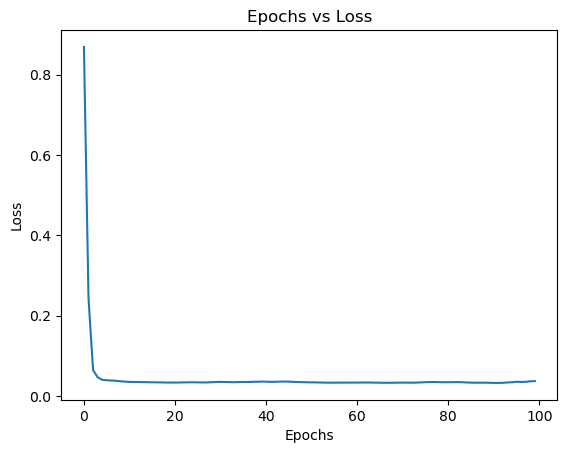

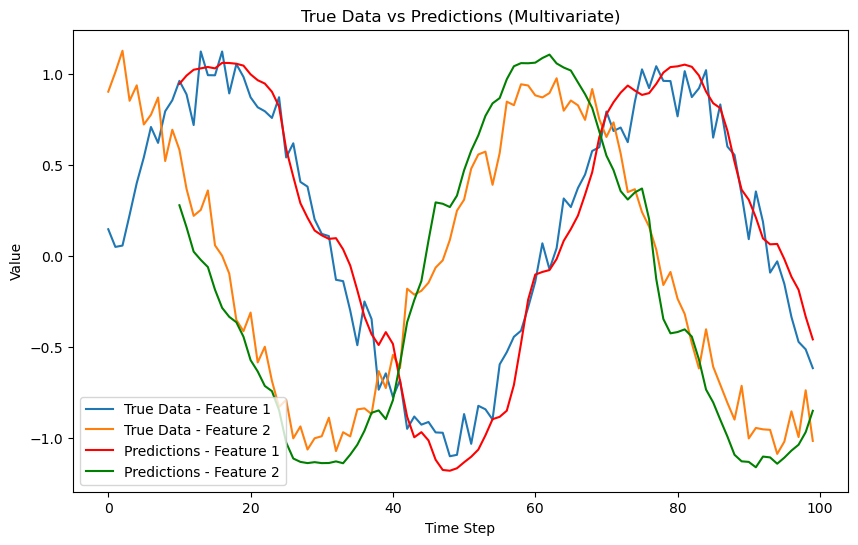

In [10]:
data_multivariate = generate_synthetic_data_multivariate(seq_length)

X_train_multivariate = [data_multivariate[i:i+window_size] for i in range(len(data_multivariate) - window_size)]
y_train_multivariate = [data_multivariate[i + window_size] for i in range(len(data_multivariate) - window_size)]

rnn_multivariate = SimpleRNN(input_size=2, hidden_size=20, output_size=2, learning_rate=0.01)
rnn_multivariate.train(X_train_multivariate, y_train_multivariate, epochs=100, window_size=window_size)

predictions_multivariate = [rnn_multivariate.predict(X_window) for X_window in X_train_multivariate]

predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 2)
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_multivariate[:, 0], label="True Data - Feature 1")
plt.plot(range(seq_length), data_multivariate[:, 1], label="True Data - Feature 2")
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 0], label="Predictions - Feature 1", color='red')
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 1], label="Predictions - Feature 2", color='green')
plt.legend()
plt.title('True Data vs Predictions (Multivariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_tesla = pd.read_excel("Tesla_Stock.xlsx")

# Drop unnecessary columns (like unnamed index column)
df_tesla = df_tesla.drop(columns=["Unnamed: 0"], errors="ignore")  # Ignore errors if column doesn't exist

# Convert 'Date' column to datetime format
df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])

# Set 'Date' as the index
df_tesla.set_index("Date", inplace=True)

# Initialize MinMaxScaler and scale the data (normalize to range 0-1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_tesla)

# Convert scaled data back to DataFrame for easier handling
df_scaled = pd.DataFrame(scaled_data, columns=df_tesla.columns, index=df_tesla.index)

# Display the first few rows of the preprocessed dataset
df_scaled.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,0.013359,0.011263,0.012148,0.012594,0.067348
2015-01-05,0.011979,0.010149,0.011122,0.011059,0.077377
2015-01-06,0.011234,0.009770,0.010626,0.011257,0.092210
2015-01-07,0.011780,0.009866,0.011563,0.011202,0.037529
2015-01-08,0.011690,0.009704,0.011602,0.011147,0.045400


Epoch 1, Loss: 0.008961439146655837
Epoch 2, Loss: 0.01219454614536527
Epoch 3, Loss: 0.008717144092841946
Epoch 4, Loss: 0.006579642109002873
Epoch 5, Loss: 0.005789192270756652
Epoch 6, Loss: 0.005672469680571812
Epoch 7, Loss: 0.005747754800726981
Epoch 8, Loss: 0.0058083932051359345
Epoch 9, Loss: 0.005811610779094913
Epoch 10, Loss: 0.005767556058410322
Epoch 11, Loss: 0.0056796806730148135
Epoch 12, Loss: 0.005573212755308795
Epoch 13, Loss: 0.005460017905541701
Epoch 14, Loss: 0.005356636972705538
Epoch 15, Loss: 0.005269582376911014
Epoch 16, Loss: 0.005201808644763863
Epoch 17, Loss: 0.005151792982853748
Epoch 18, Loss: 0.005116930684914613
Epoch 19, Loss: 0.005093292349498432
Epoch 20, Loss: 0.005077385149112951
Epoch 21, Loss: 0.0050678294565053095
Epoch 22, Loss: 0.005064076857990275
Epoch 23, Loss: 0.005065323340185553
Epoch 24, Loss: 0.0050710136116758255
Epoch 25, Loss: 0.005080424569150252
Epoch 26, Loss: 0.005092357230610092
Epoch 27, Loss: 0.005105673318405296
Epoch 2

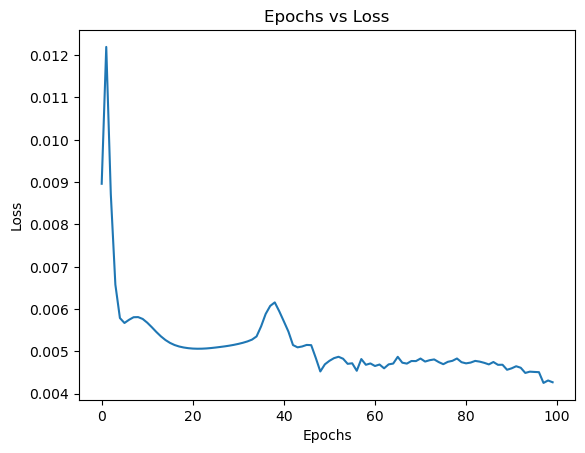

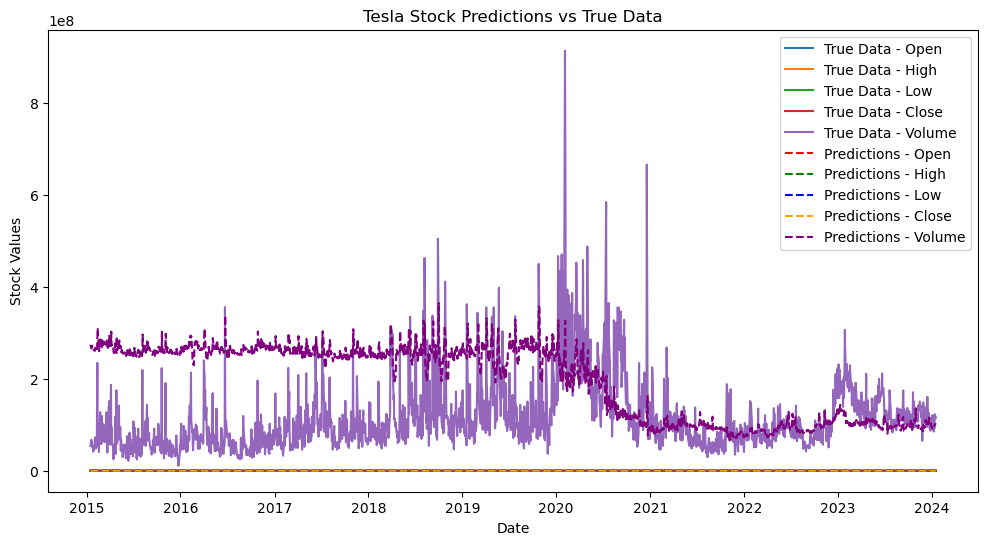

In [12]:
# Define window size
window_size = 10

# Convert the Tesla stock dataset into training sequences
X_train_multivariate = [df_scaled.values[i:i+window_size] for i in range(len(df_scaled) - window_size)]
y_train_multivariate = [df_scaled.values[i + window_size] for i in range(len(df_scaled) - window_size)]

# Convert to NumPy arrays
X_train_multivariate = np.array(X_train_multivariate)
y_train_multivariate = np.array(y_train_multivariate)

# Initialize the RNN model
rnn_multivariate = SimpleRNN(input_size=5, hidden_size=20, output_size=5, learning_rate=0.01)

# Train the model
rnn_multivariate.train(X_train_multivariate, y_train_multivariate, epochs=100, window_size=window_size)

# Make predictions
predictions_multivariate = [rnn_multivariate.predict(X_window) for X_window in X_train_multivariate]

# Convert predictions to a NumPy array
predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 5)

# Inverse transform predictions back to original scale
predictions_multivariate = scaler.inverse_transform(predictions_multivariate)
y_train_actual = scaler.inverse_transform(y_train_multivariate)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 0], label="True Data - Open")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 1], label="True Data - High")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 2], label="True Data - Low")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 3], label="True Data - Close")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 4], label="True Data - Volume")

plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 1], label="Predictions - High", color='green', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 2], label="Predictions - Low", color='blue', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 3], label="Predictions - Close", color='orange', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 4], label="Predictions - Volume", color='purple', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()